In [1]:
import os,pickle
import matplotlib.pylab as plt
from pynbody.sph import smooth
from scipy.interpolate import UnivariateSpline as Smooth
import numpy as np
#import argparse
import traceback
import pathlib
import sys
#parser = argparse.ArgumentParser(description='Smoothly interpolate Radial Bins for Shapes')
#args = parser.parse_args()
verbose = False
path = '/home/bk639/MorphologyMeasurements/Code'
sys.path.append(path)
#print(sys.path)

# Import the SimInfoDicts package
from SimInfoDicts.sim_type_name import sim_type_name


from scipy.ndimage import gaussian_filter1d, label
from scipy.interpolate import interp1d


def gaussian_smooth(x, y, distance=0.2, sigma=6):
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # Create a new array for smoothed y values
    y_smooth = np.zeros_like(y_sorted)

    for i, xi in enumerate(x_sorted):
        # Find indices of points within the specified distance
        mask = np.abs(x_sorted - xi) <= distance
        x_window = x_sorted[mask]
        y_window = y_sorted[mask]

        # Apply Gaussian smoothing to the window
        if len(y_window) > 1:
            y_smooth[i] = gaussian_filter1d(y_window, sigma)[0]
        else:
            y_smooth[i] = y_window[0]

    # Clip values between 0 and 1
    y_smooth = np.clip(y_smooth, 0, 1)

    # Create an interpolation function
    f = interp1d(x_sorted, y_smooth, kind='cubic', fill_value='extrapolate')

    # Display a warning if y values are not between 0 and 1
    if np.any(y_smooth < 0) or np.any(y_smooth > 1):
        print(
            'Warning: Some smoothed values are not in the physical range [0, 1]')

    # # Return a callable function that clips the output between 0 and 1
    # return lambda x_new: np.clip(f(x_new), 0, 1)
    return f

import numpy as np
from scipy.interpolate import UnivariateSpline

# 
# def nanfunction(x):
#     return x*0 +10

from scipy.interpolate import UnivariateSpline
def smooth_and_filter_data(rbins, ba, ca,k=5):
    s_factor=1
    """
    Smooth and filter data, handling a few NaN values gracefully.

    Parameters:
    rbins, ba, ca: array-like, input data
    k: int, degree of the smoothing spline (default 3)
    s_factor: float, smoothing factor as a fraction of len(rbins) (default 0.01)
    residual_threshold, jump_threshold, jump_percentage: unused in this version

    Returns:
    rbins, ba, ca: filtered arrays
    ba_s, ca_s: smoothed spline functions
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    # Remove rows where either ba or ca is NaN
    mask = ~np.isnan(ba) & ~np.isnan(ca)
    rbins_filtered = rbins[mask]
    ba_filtered = ba[mask]
    ca_filtered = ca[mask]

    # Calculate smoothing parameter
    s = s_factor * len(rbins_filtered)

    # Create splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # Print some diagnostic information
    # print(f"Total data points: {len(rbins)}")
    # print(f"Data points after NaN removal: {len(rbins_filtered)}")
    # print(f"NaN percentage: {(1 - len(rbins_filtered)/len(rbins))*100:.2f}%")

    n = len(rbins_filtered)
    #calculate residuals and remove outliers
    ba_residuals = ba_filtered - ba_s(rbins_filtered)
    ca_residuals = ca_filtered - ca_s(rbins_filtered)
    #calculate the standard deviation of the residuals
    ba_std = np.std(ba_residuals)
    ca_std = np.std(ca_residuals)
    #remove outliers
    d = 3


    mask = np.abs(ba_residuals) < d*ba_std


    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    mask = np.abs(ca_residuals[mask]) < d*ca_std
    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    #remove any points that are isolated in space
    #calculate the difference between each point

    diff = np.diff(rbins_filtered,prepend=0)
    #print(diff)
    #mask isolated points
    mask = diff > 1
    #print(mask)
    # print(rbins_filtered[mask])
    # print(diff[mask])
    rbins_filtered = rbins_filtered[~mask]
    ba_filtered = ba_filtered[~mask]
    ca_filtered = ca_filtered[~mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)
        # Print some diagnostic information
    # print(f"Data points after outlier removal: {len(rbins_filtered)}")
    # print(f"Outlier percentage: {(1 - len(rbins_filtered)/len(rbins))*100:.2f}%")

    #clip the function to 0,1
    ba_s_c = lambda x: np.clip(ba_s(x),0,1)
    ca_s_c = lambda x: np.clip(ca_s(x),0,1)
    
    return rbins_filtered, ba_filtered, ca_filtered, ba_s_c, ca_s_c



Calculating masses for MerianCDM feedback type.
Saving ../../Figures/CombinedShapes/r431.MerianCDMShapes.1.png
Saving ../../Figures/CombinedShapes/r563.MerianCDMShapes.1.png
Saving ../../Figures/CombinedShapes/r850.MerianCDMShapes.1.png
Calculating masses for BWMDC feedback type.


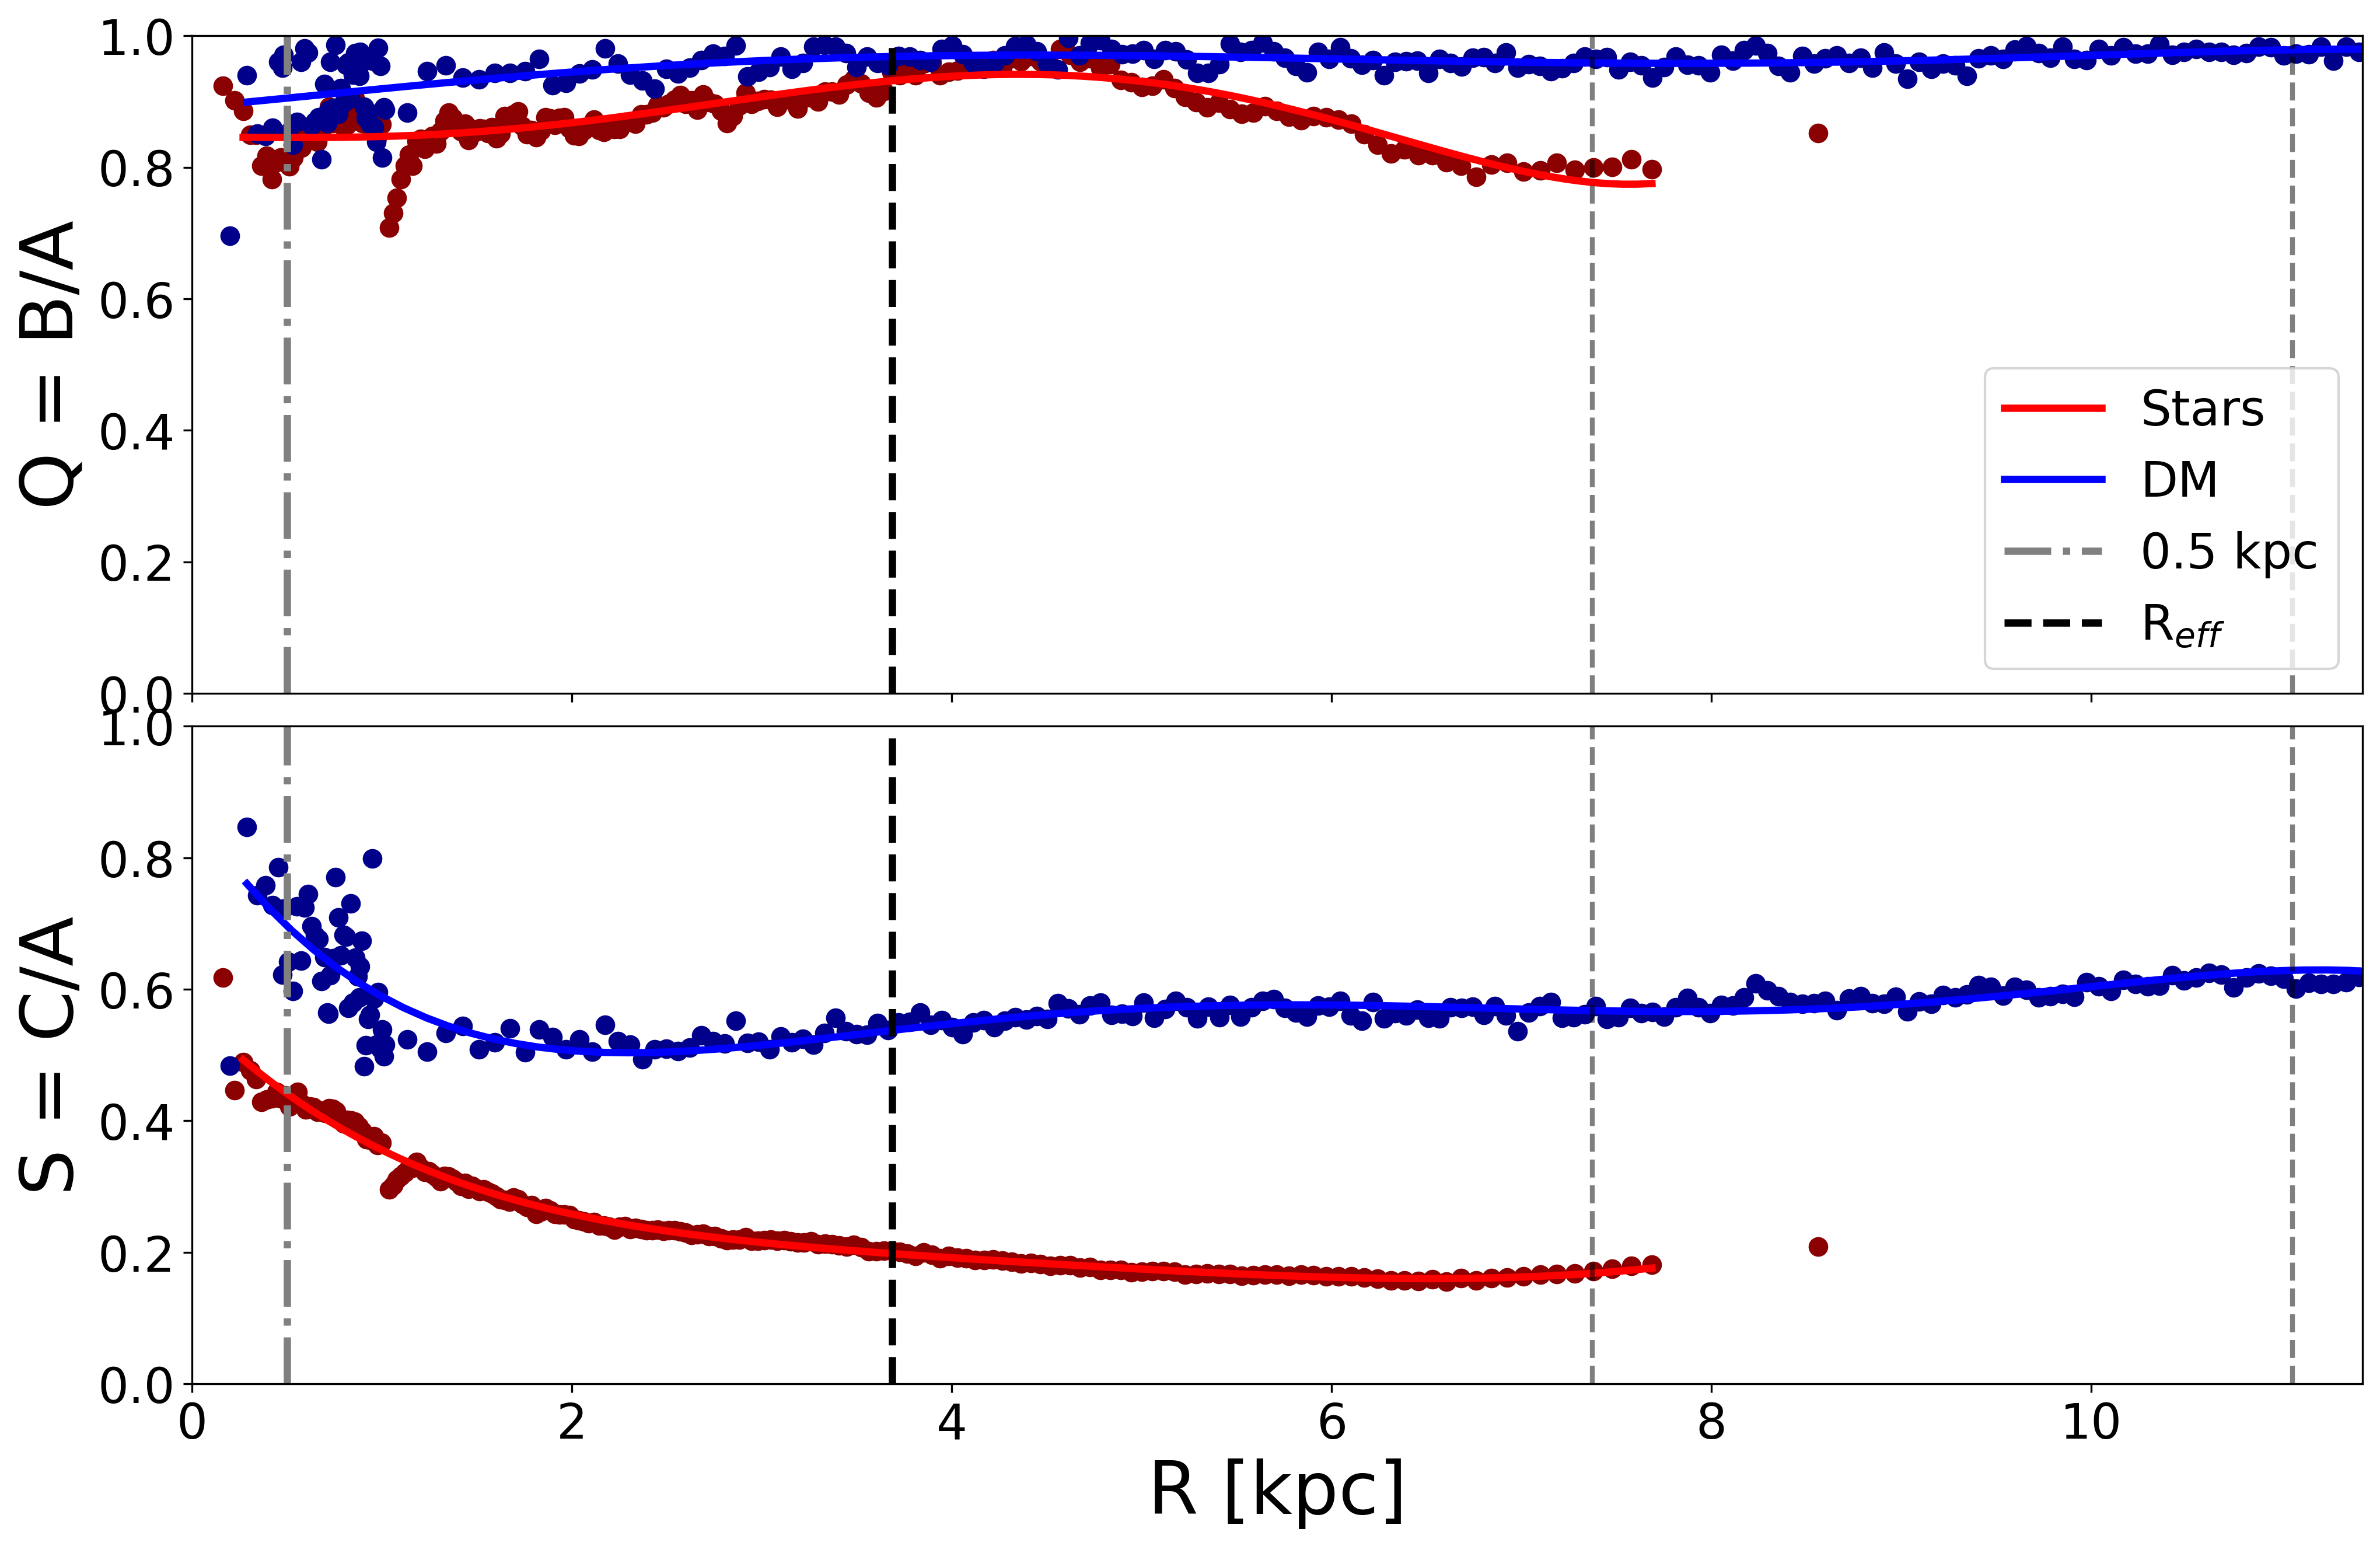

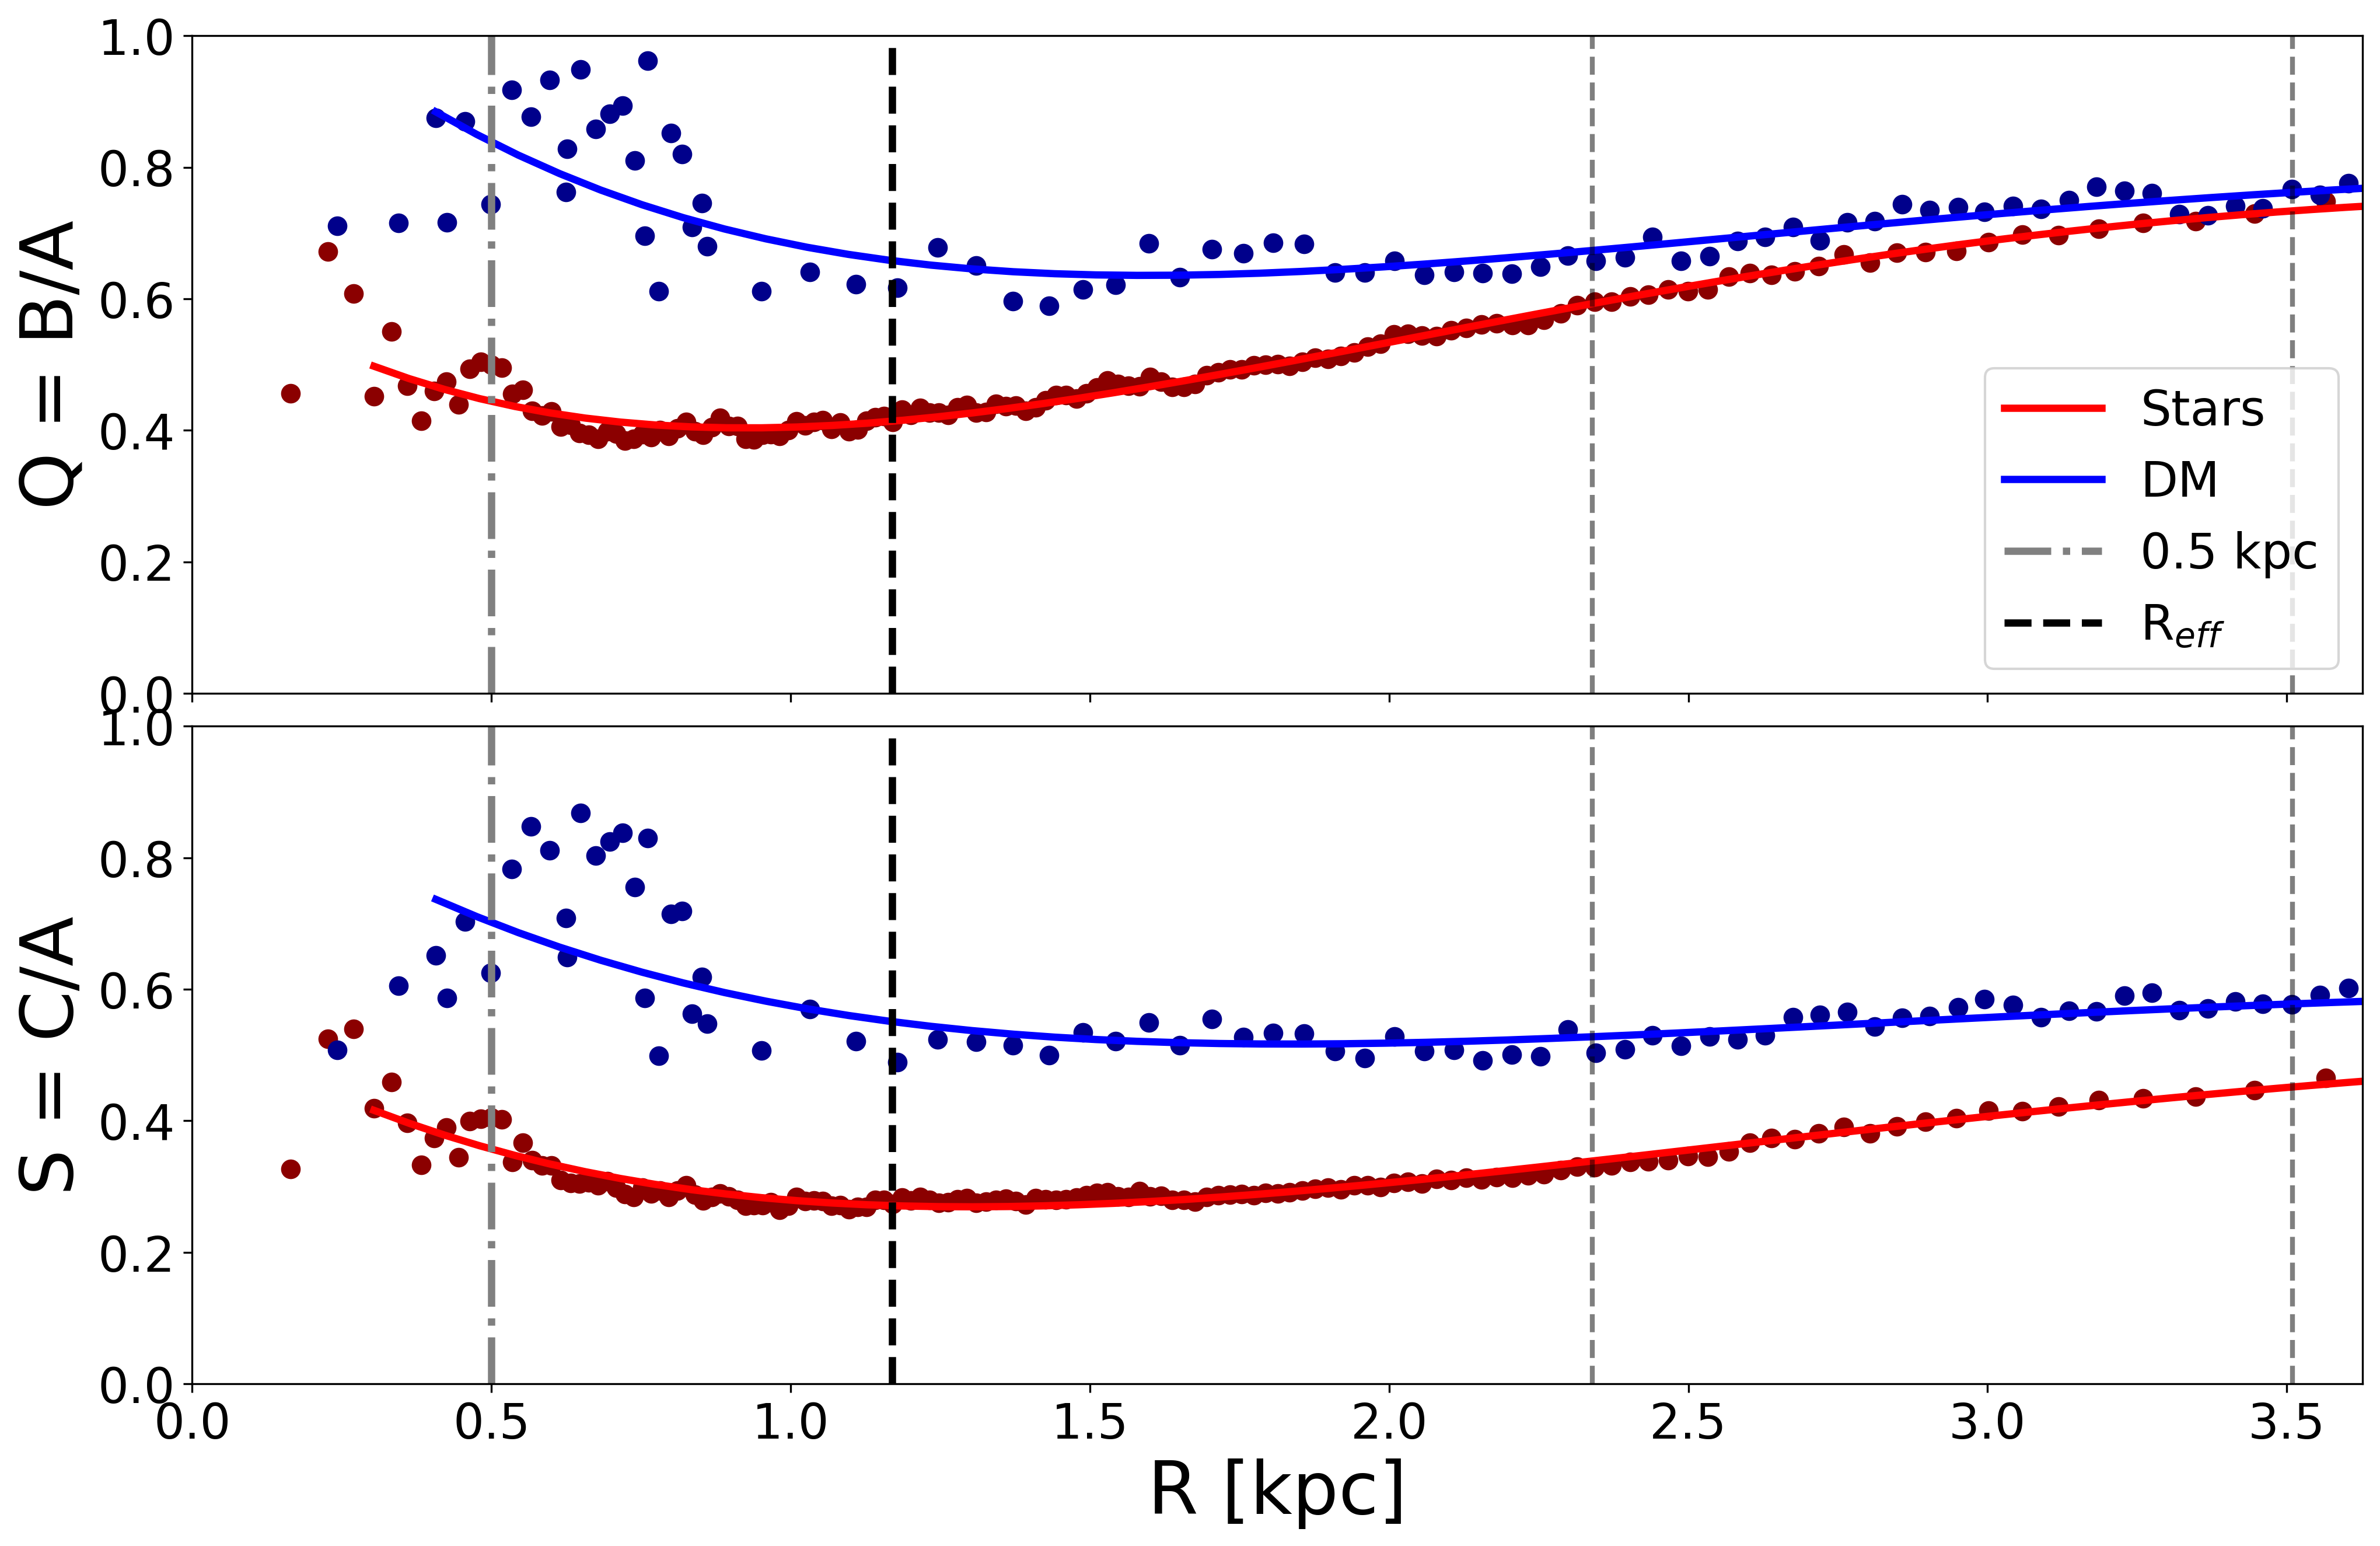

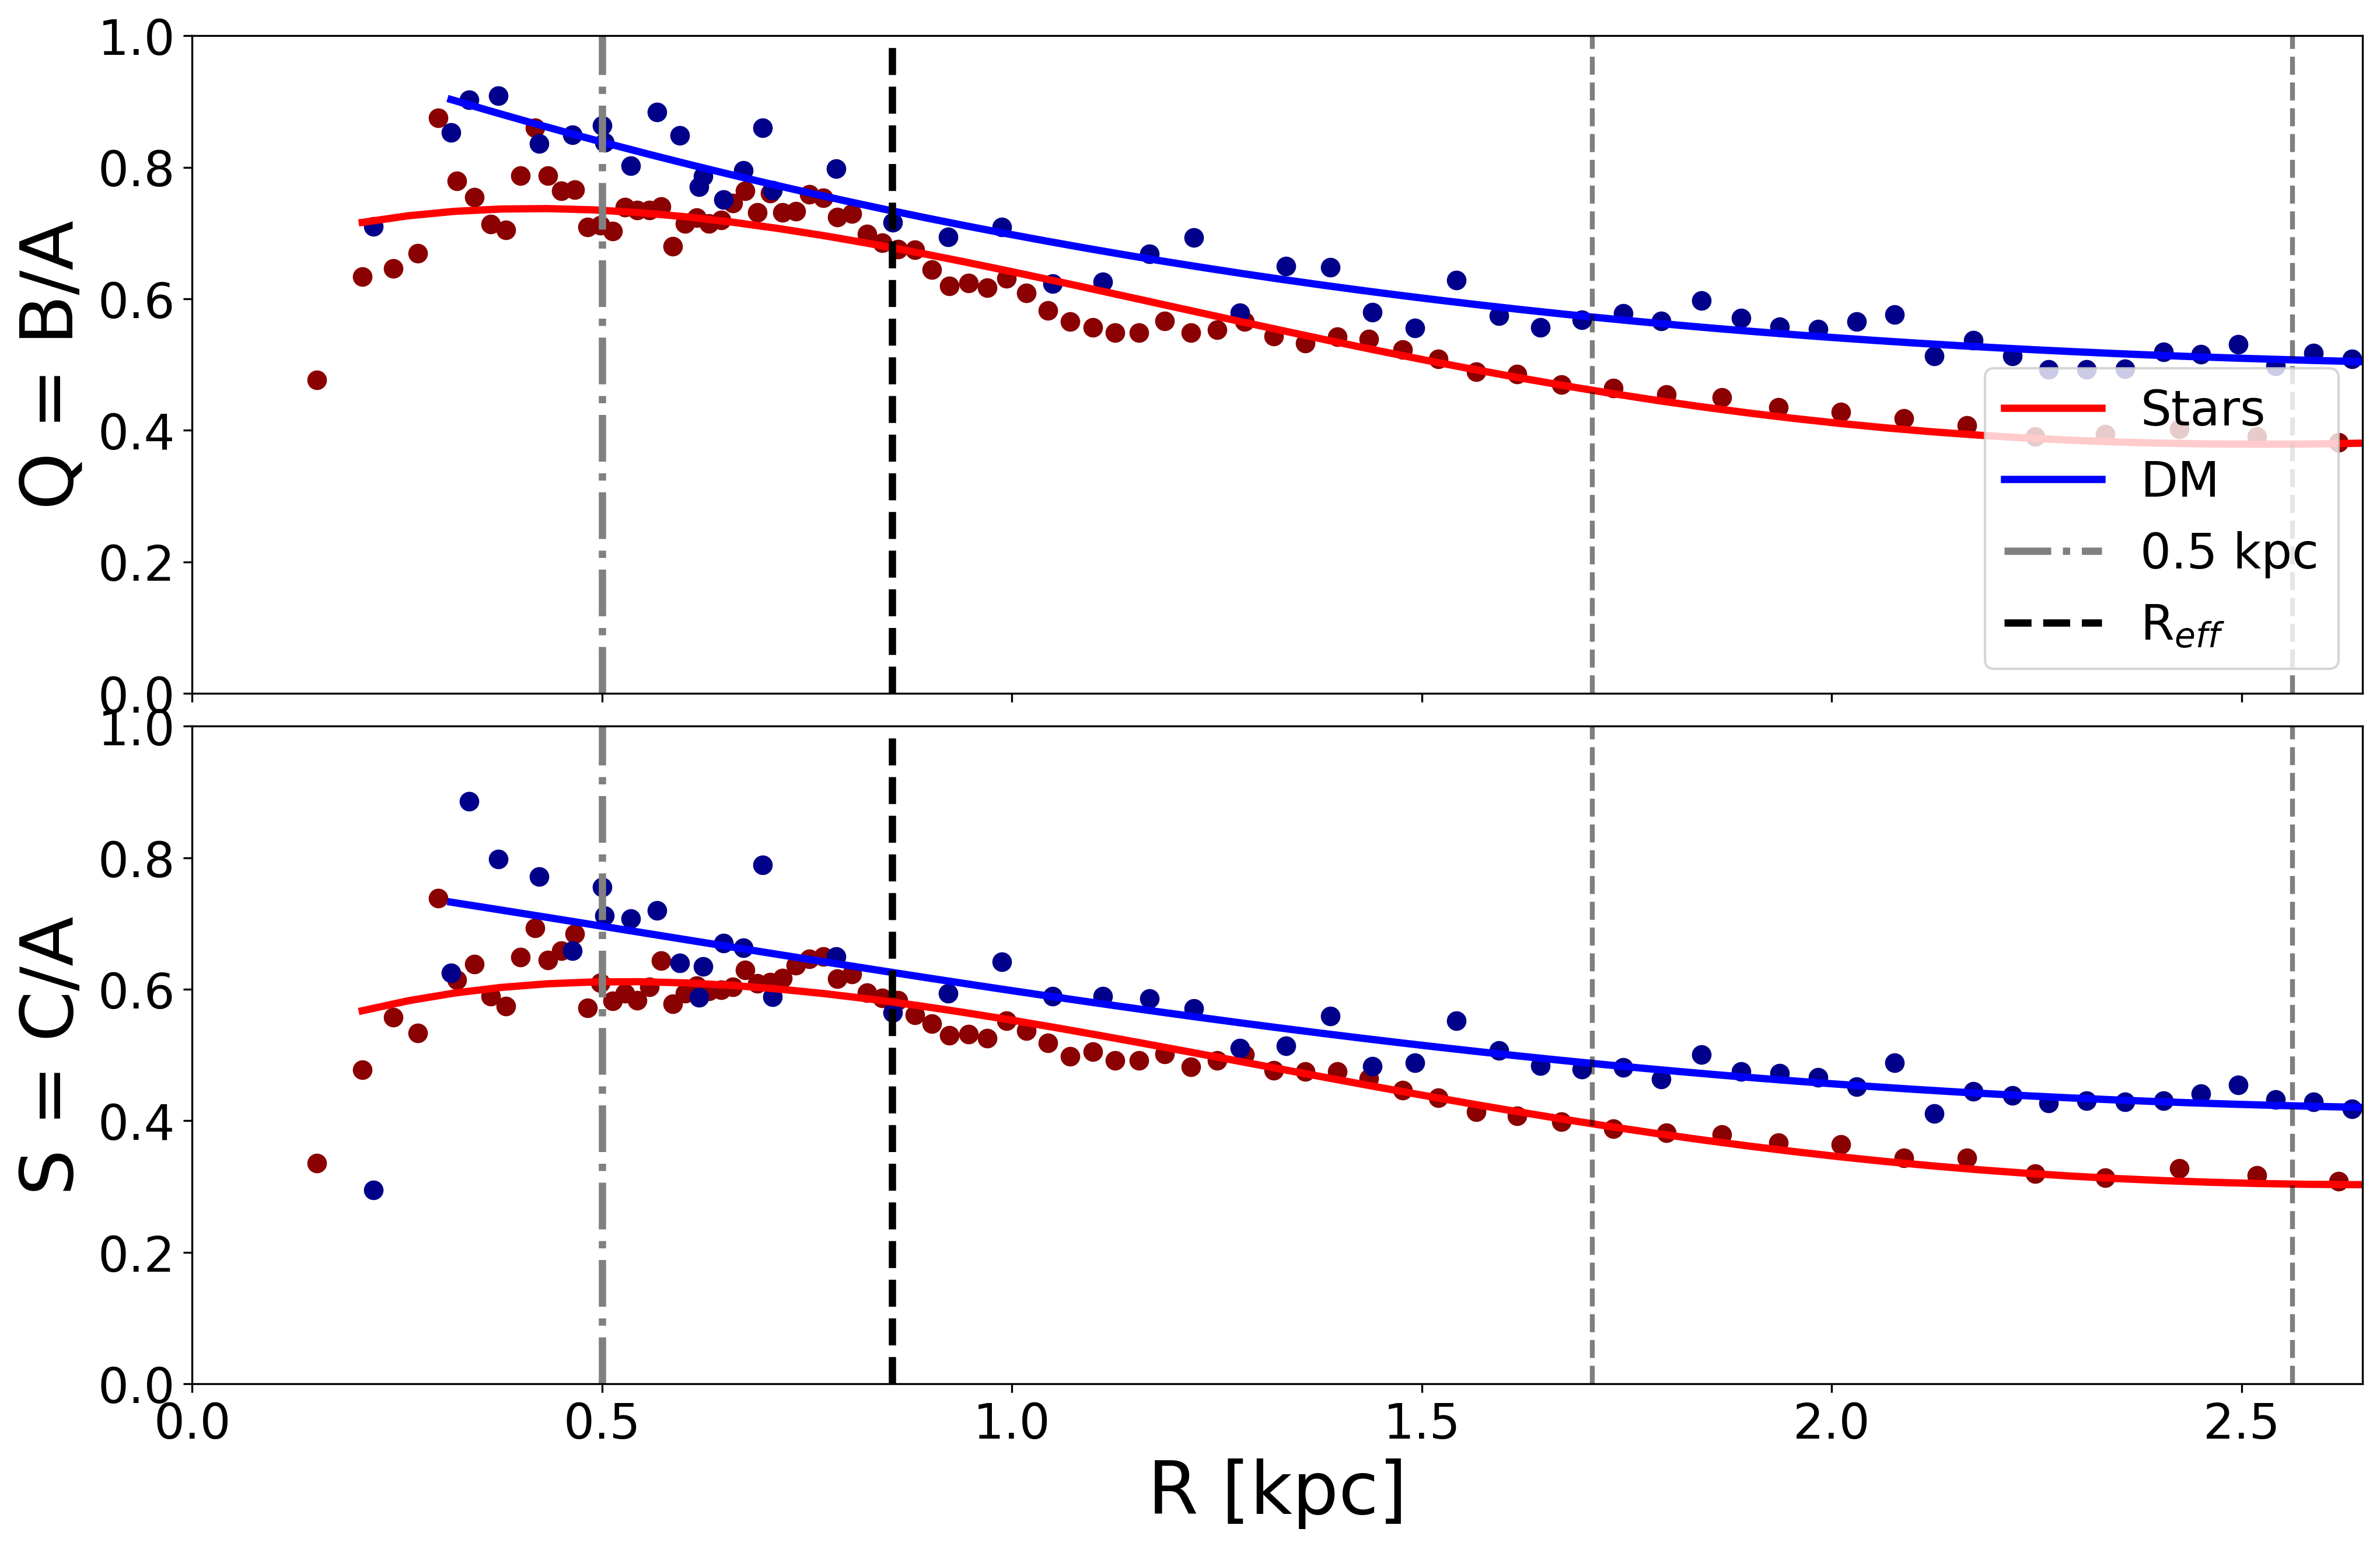

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import traceback
from scipy.interpolate import interp1d
from SimInfoDicts.sim_type_name import sim_type_name

sim_type_name['BWMDC'] = True
sim_type_name['MerianCDM'] = True
sim_type_name['MerianSIDM'] = False
#sims_to_use = ['r597.romulus25si2s50v35']
sims_to_use = ['r431','r563','r850'] #example sims for paper

def plot_combined_shapes(SimInfo, feedback, sims_to_use, verbose=False):
    for sim in SimInfo:
        # if sim not in sims_to_use:
        #     continue

        try:
            DMShapes = pickle.load(open(f'../../Data/{sim}.{feedback}.DMShapes.pickle', 'rb'))
            StarShapes = pickle.load(open(f'../../Data/{sim}.{feedback}.3DShapes.pickle', 'rb'))
            Profiles = pickle.load(open(f'../../Data/{sim}.{feedback}.Profiles.pickle', 'rb'))
        except FileNotFoundError as e:
            print(f'Error loading pickle files for {sim}: {e}')
            continue

        for hid in SimInfo[sim]['goodhalos']:
            try:
                dm_rbins, dm_ba, dm_ca = DMShapes[hid]['rbins'], DMShapes[hid]['ba'], DMShapes[hid]['ca']
                star_rbins, star_ba, star_ca = StarShapes[hid]['rbins'], StarShapes[hid]['ba'], StarShapes[hid]['ca']
                r_80 = StarShapes[hid]['r_80']

                reffs = []
                for angle in Profiles[str(hid)]:
                    try:
                        reffs.append(Profiles[str(hid)][angle]['Reff'])
                    except IndexError:
                        if verbose:
                            print(f'IndexError angle {angle} for halo {hid} in {sim}.{feedback}.Profiles.pickle')
                    break

                if len(dm_rbins) > 0 and len(star_rbins) > 0:
                    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True,dpi=300)
                    axes = [ax1, ax2]
                    #remove hspace
                    plt.subplots_adjust(hspace=0.05)
                    ratios = ['B/A', 'C/A']
                    colors = {'DM': ['blue', 'darkblue'], 'Stars': ['red', 'darkred']}
                    s = 50

                    #get star data
                    k = 5
                    if sim == 'r431':
                        k = 5
                    r_bins, ba_f, ca_f, ba_s, ca_s = smooth_and_filter_data(star_rbins, star_ba, star_ca,k = k)
                    if sim == 'r431':
                        r_bins = r_bins[0:-1]
                    #print(star_rbins)
                    r_smooth = np.linspace(min(r_bins), max(r_bins), 100)
                    ax1.plot(r_smooth, ba_s(r_smooth), c=colors['Stars'][0], linestyle='-', lw=3, label='Stars')
                    ax2.plot(r_smooth, ca_s(r_smooth), c=colors['Stars'][0], linestyle='-', lw=3)
                    #ax1.plot(star_rbins, star_ba, c=colors['Stars'][1],label = 'Stars Raw', lw=3, ls='--')
                    #ax2.plot(star_rbins, star_ca, c=colors['Stars'][1], lw=3, ls='--')
                    #raw data scatter
                    ax1.scatter(star_rbins, star_ba, c=colors['Stars'][1], s=s)
                    ax2.scatter(star_rbins, star_ca, c=colors['Stars'][1], s=s)

                    #get dark matter data
                    r_bins, ba_f, ca_f, ba_s, ca_s = smooth_and_filter_data(dm_rbins, dm_ba, dm_ca)
                    r_smooth = np.linspace(min(r_bins), max(r_bins), 100)
                    ax1.plot(r_smooth, ba_s(r_smooth), c=colors['DM'][0], linestyle='-', lw=3, label='DM')
                    ax2.plot(r_smooth, ca_s(r_smooth), c=colors['DM'][0], linestyle='-', lw=3)
                    # ax1.plot(dm_rbins, dm_ba, c=colors['DM'][1], label = 'DM Raw', lw=3, ls='--')
                    # ax2.plot(dm_rbins, dm_ca,c=colors['DM'][1], lw=3, ls='--')
                    ax1.scatter(dm_rbins, dm_ba, c=colors['DM'][1], s=s)
                    ax2.scatter(dm_rbins, dm_ca, c=colors['DM'][1], s=s)
                    #ax1.set_xscale('log')



                    for ax in (ax1, ax2):
                        for j in range(2, 4):
                            ax.axvline(j*reffs[0], c='k', alpha=0.5,lw = 2,ls = '--')
                        ax.axvline(0.5, c='gray', alpha=1, lw = 3, ls = '-.', label='0.5 kpc')
                        ax.axvline(reffs[0], c='k', alpha=1, label=r'R$_{eff}$', lw = 3, ls = '--')
                        #ax1.set_title(f'{sim} halo {hid}', fontsize=30)
                        ax2.set_xlabel('R [kpc]', fontsize=30)
                        #ax.legend(loc='lower right', prop={'size': 20})
                        ax.set_ylim([0, 1])
                        ax.tick_params(which='both',labelsize=20)
                        #ax.axvline(r_80, c=colors['Stars'][1], alpha=0.5, lw=2, ls='dotted', label=r'R$^*_{80}$')
                        #remove grids
                        ax.grid(False)
                    ax1.legend(loc='lower right', prop={'size': 20})
                    ax1.set_ylabel('Q = B/A', fontsize=30)
                    ax2.set_ylabel('S = C/A', fontsize=30)

                    ax1.set_xlim([0, 3.1*reffs[0]])

                    if not os.path.exists(f'../../Figures/CombinedShapes'):
                        os.makedirs(f'../../Figures/CombinedShapes')
                    filename = f'../../Figures/CombinedShapes/{sim}.{feedback}Shapes.{hid}.png'
                    print(f'Saving {filename}')

                    #save also to /home/bk639/OverLeaf/ShapePaper/figures/
                    #filename = f'/home/bk639/OverLeaf/ShapePaper/figures/{sim}.{feedback}Shapes.{hid}.png'

                    #f.savefig(filename, bbox_inches='tight', pad_inches=.1)
                    #plt.show()
                    plt.close()
                    
                    #save results to corresponding pickle file
                    DMShapes[hid]['ba_smooth'] = ba_s
                    DMShapes[hid]['ca_smooth'] = ca_s
                    StarShapes[hid]['ba_smooth'] = ba_s
                    StarShapes[hid]['ca_smooth'] = ca_s
                    #pickle.dump(DMShapes, open(f'../../Data/{sim}.{feedback}.DMShapes.pickle', 'wb'))
                    #pickle.dump(StarShapes, open(f'../../Data/{sim}.{feedback}.3DShapes.pickle', 'wb'))

            except Exception as e:
                print(traceback.format_exc())
                print(f"An error processing sim {sim} halo {hid}: {e}")



# Usage
for feedback, use_sim in sim_type_name.items():
    if use_sim:
        print(f'Calculating masses for {feedback} feedback type.')
        pickle_path = f'../PickleFiles/SimulationInfo.{feedback}.pickle'
        if os.path.exists(pickle_path):
            SimInfo = pickle.load(open(pickle_path, 'rb'))
            plot_combined_shapes(SimInfo, feedback, sims_to_use)
